# Examining Pipeline Outputs

This notebook demonstrated the parsing of output data from the `snat_sim` pipeline.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, '../')
from snat_sim.utils import *


## Parsing Data

Results from the analysis pipeline are written to disk over multiple files. We read data from each file and concatenate the results. 

Values that are not fit for are masked using the value `-99.99`. For conveniance, we replace these values with `nan` in the below example. 

For a full overview of the output file data model, see the official project documentation.


In [2]:
def get_combined_data(directory, key):
    """Return data from directory of pipeline HDF5 files
    
    Returns concatenated tables from each of the files.
    
    Args:
        directory (Path): The directory to parse data files from
        key: Key of the table in the HDF5 files
        
    Returns:
        A pandas datafram with pipeline data
    """

    dataframes = []
    for file in directory.glob('*.h5'):
        with pd.HDFStore(file, 'r') as datastore:
            dataframes.append(datastore.get(key))
            
    if not dataframes:
        raise ValueError('No h5 files found in given directory')
            
    return pd.concat(dataframes).set_index('snid')
    

In [3]:
base_dir = Path.home() / 'Downloads'
sim_params = get_combined_data(base_dir, '/simulation/params')
fit_results = get_combined_data(base_dir, '/fitting/params')

# Combine the imput simulation parameters and the fit results into a single dataframe
# The keys in ``fit_results`` are expected to be a proper subset of ``sim_params``
# so we left join on ``fit_results``
pipeline_data = fit_results.join(sim_params)

# Join results for failed fit results will be nan.
pipeline_data = pipeline_data.replace(-99.99, np.nan)
pipeline_data.head()


,fit_z,fit_t0,fit_x0,fit_x1,fit_c,fit_pwv,err_z,err_t0,err_x0,err_x1,...,ndof,apparent_bessellb,absolute_bessellb,ra,dec,t0,x1,c,z,x0
snid,,,,,,,,,,,,,,,,,,,,,
34899822.0,0.204207,62592.957031,0.000057,-2.774871,0.237039,4.0,NaN,NaN,1.164757e-05,1.050070,...,170.0,21.118992,-18.891406,331.171875,-7.933337,62592.957031,-2.127167,-0.062742,0.204207,0.000090
42772166.0,0.624862,60471.050781,0.000005,0.942250,-0.010849,4.0,NaN,NaN,1.416777e-07,0.272354,...,167.0,23.765451,-19.089481,312.187500,1.940072,60471.050781,0.909768,-0.049209,0.624862,0.000009
12389513.0,0.756883,61458.265625,0.000003,-0.974857,-0.079830,4.0,NaN,NaN,1.649242e-07,0.320965,...,155.0,24.325507,-19.037734,86.297470,-60.812271,61458.265625,-0.479638,-0.100458,0.756883,0.000006
52615291.0,0.738360,62260.902344,0.000003,1.750491,0.030446,4.0,NaN,NaN,1.149061e-07,0.355945,...,206.0,24.209266,-19.089865,184.042969,-25.944481,62260.902344,1.234636,-0.011925,0.738360,0.000006
10086146.0,0.240221,60059.062500,0.000046,-2.253709,0.028539,4.0,NaN,NaN,3.816599e-07,0.083699,...,120.0,21.350964,-19.057293,213.750000,-65.696335,60059.062500,-2.228127,0.024379,0.240221,0.000048


## Plotting Pipeline Results

We create a simple corner plot comparing the imput simulation parameters and the corresponding fit results.

In [4]:
def build_data_iter(axes, df, limit=None):
    """Build an iterator over plotting data from a dataframe of pipeline outputs
    
    Args:
        axes    (list): An array of plotting axes
        df (Dataframe): Plotting data
        limit    (int): Optionaly limit the number of yielded values
        
    Returns:
        An iterator over an index, axes, and dataframe columns
    """
    
    limit = range(limit + 1) if limit is not None else range(len(axes))
    return (
        (i, fig_row, label, data) for 
        (i, fig_row, (label, data)) in 
        zip(limit, axes, df.iteritems())
    )
    

In [5]:
def corner_plot_fit_results(data, x_vals, y_vals, figsize=(20, 20)): 
    """Create a corner plot of pipeline fit results
    
    Args:
        data (Dataframe): Pipeline output data
        x_vals    (list): Column names to use as x values
        y_vals    (list): Column names to use as y values
        figsize  (typle): The size of the figure
    """
    
    lin_fit_style = dict(color='k', linestyle='--')
    
    fig, axes = plt.subplots(len(x_vals), len(y_vals), figsize=figsize)

    x_iter = build_data_iter(axes, data[x_vals])
    for i, fig_row, xlabel, xdata in x_iter:

        y_iter = build_data_iter(fig_row, data[y_vals], limit=i)
        for j, axis, ylabel, ydata in y_iter:
            axis.scatter(xdata, ydata, alpha=.25)
            
            if i == j:
                m, b = np.polyfit(xdata, ydata, 1)
                fit = np.poly1d((m, b))
                axis.plot(xdata, fit(xdata), **lin_fit_style, label=f'm={m:.2f} b={b:.2f}')
                
                axis.legend()

    for axis, label in zip(axes[-1,:], x_vals):
        axis.set_xlabel(label)

    for axis, label in zip(axes[:,0], y_vals):
        axis.set_ylabel(label)
    

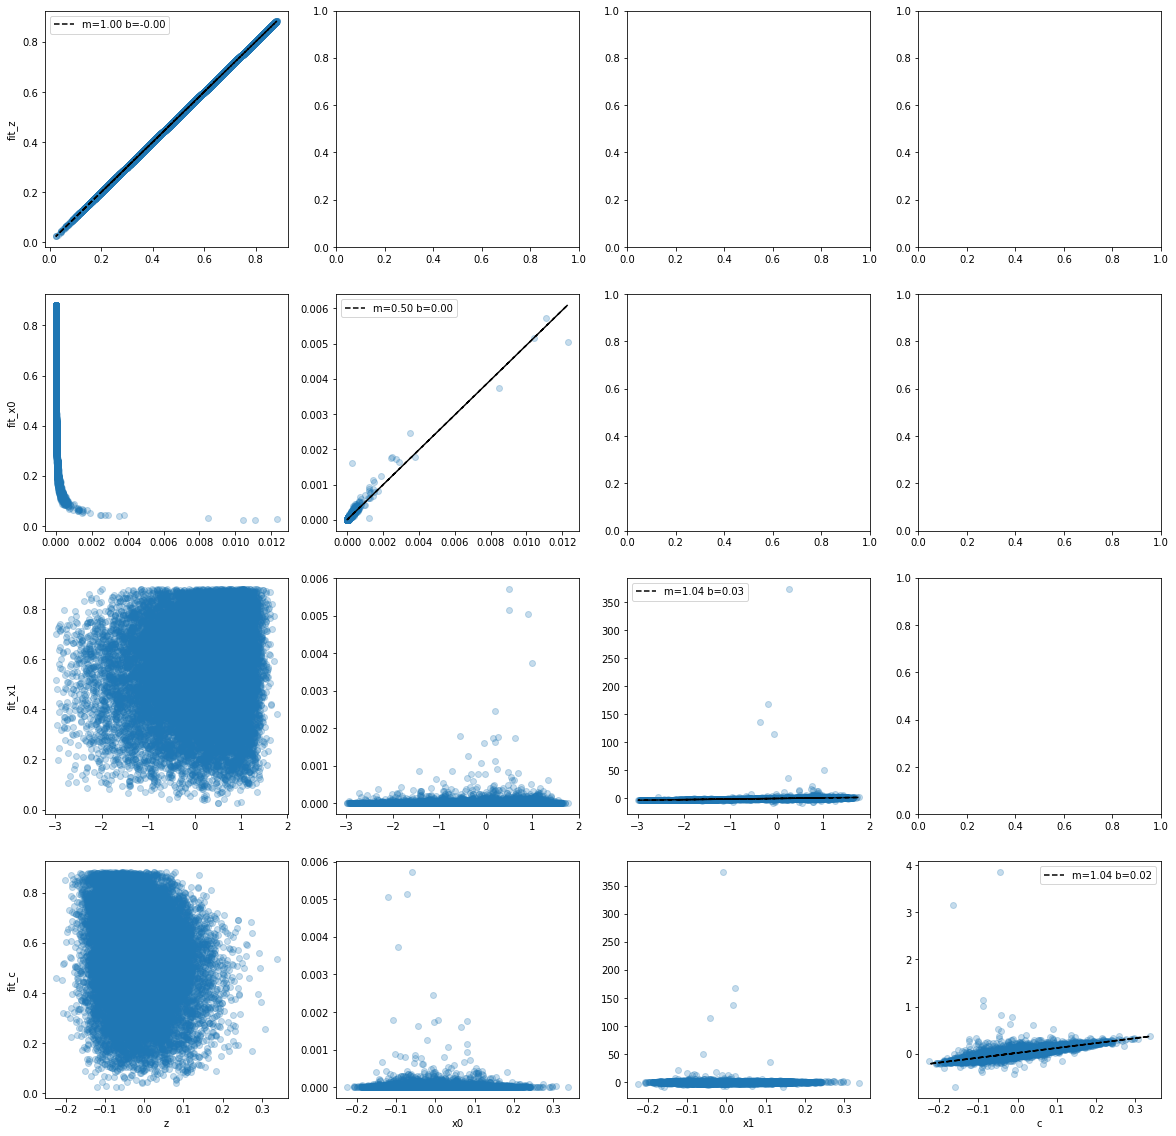

In [6]:
corner_plot_fit_results(
    data = pipeline_data,
    x_vals = ['z', 'x0', 'x1', 'c'],
    y_vals = ['fit_z', 'fit_x0', 'fit_x1', 'fit_c'])
